### Laboratorium 4 - zadania

In [2]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries, slic

#### Zadanie 1

Dane są obrazy `tabby` i `pills`. Wykonaj dla nich segmentację przy użyciu algorytmu SLIC. Celem jest uzyskanie **jednolitych**  superpikseli, a więc zawierających tylko fragmenty obiektów lub tylko tła (a nie jednego i drugiego naraz). Przeanalizuj zachowanie algorytmu dla różnej liczby superpikseli i parametru sigma.

Zwróć uwagę, że wynikiem działania scikitowej implementacji SLIC - [`skimage.segmentation.slic`](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.slic) - (podobnie jak wielu innych algorytmów klasyfikacyjnych) jest obraz typu `np.int64` przyporządkowujący każdemu pikselowi obrazu wejściowego indeks superpiksela. Takiej reprezentacji oczekuje też funkcja [`mark_boundaries`](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.mark_boundaries).

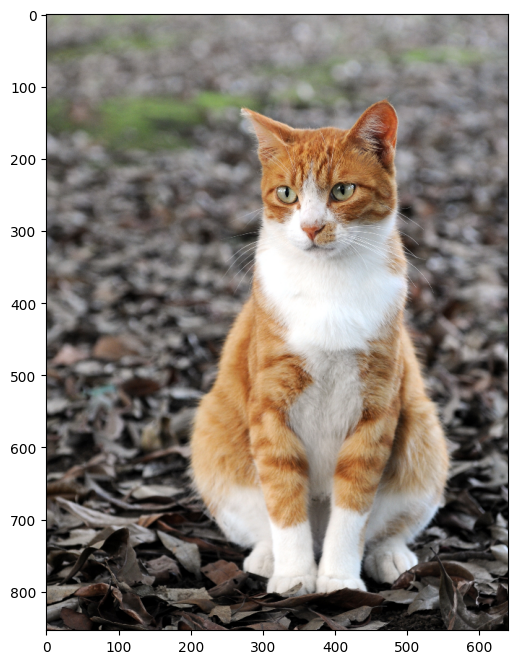

In [3]:
_ = cv2.imread('tabby.jpg')[..., ::-1]
tabby = cv2.resize(_, dsize=None, fx=0.3, fy=0.3)
plt.subplots(1,1,figsize=(8,8))[1].imshow(tabby);

In [4]:
def slic_segments_comparison(img, n_segments_list, sigma = 10):
    _, axs = plt.subplots(len(n_segments_list) // 3 + 1, 3, figsize = (15, 5 * len(n_segments_list) // 3 + 1))
    axs[0][0].imshow(img)
    axs[0][0].axis('off')
    axs[0][0].set_title('Original image')

    for i, n in enumerate(n_segments_list):
        segments = slic(img, n_segments = n, sigma = sigma)
        axs[(i + 1) // 3][(i + 1) % 3].imshow(mark_boundaries(img, segments, color = (1, 0, 0)))
        axs[(i + 1) // 3][(i + 1) % 3].axis('off')
        axs[(i + 1) // 3][(i + 1) % 3].set_title(f'n_segments = {n}')
    plt.suptitle(f'sigma = {sigma}', fontsize = 20)
    plt.show()


def slic_sigma_comparison(img, n_sigma_list, n_segments = 300):
    _, axs = plt.subplots(len(n_sigma_list) // 3 + 1, 3, figsize = (15, 5 * len(n_sigma_list) // 3 + 1))
    axs[0][0].imshow(img)
    axs[0][0].axis('off')
    axs[0][0].set_title('Original image')

    for i, s in enumerate(n_sigma_list):
        segments = slic(img, n_segments = n_segments, sigma = s)
        axs[(i + 1) // 3][(i + 1) % 3].imshow(mark_boundaries(img, segments, color = (1, 0, 0)))
        axs[(i + 1) // 3][(i + 1) % 3].axis('off')
        axs[(i + 1) // 3][(i + 1) % 3].set_title(f'sigma = {s}')
    plt.suptitle(f'n_segments = {n_segments}', fontsize = 20)
    plt.show()

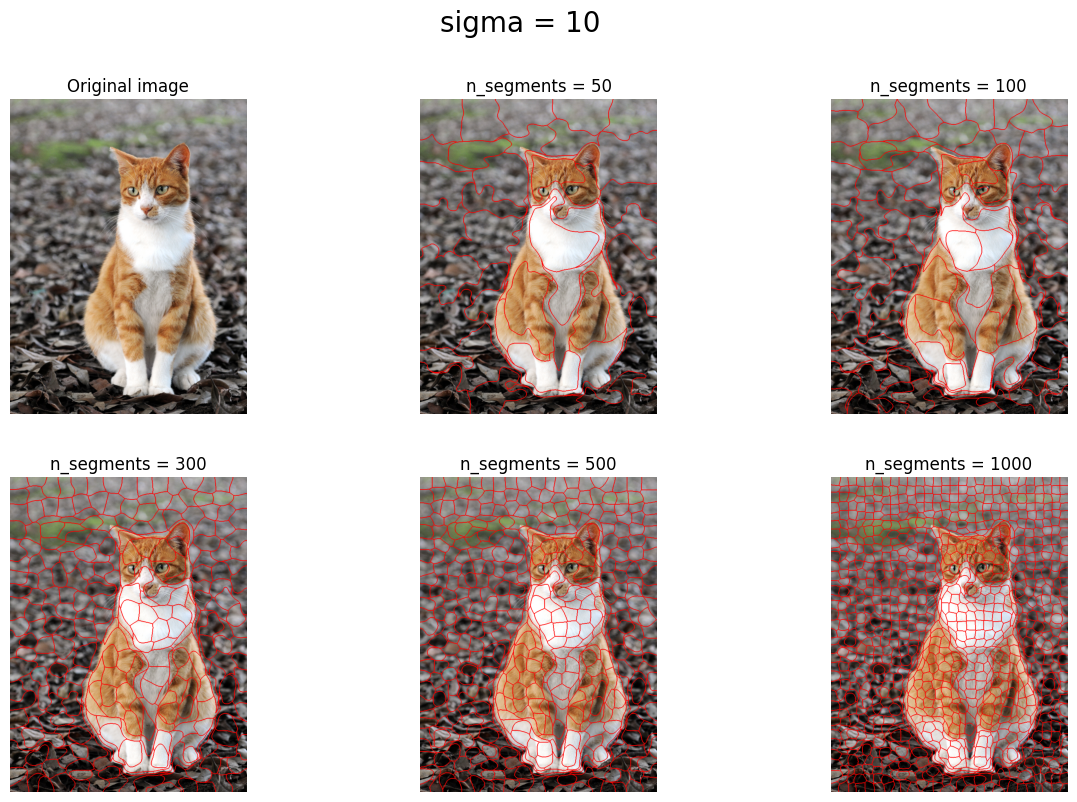

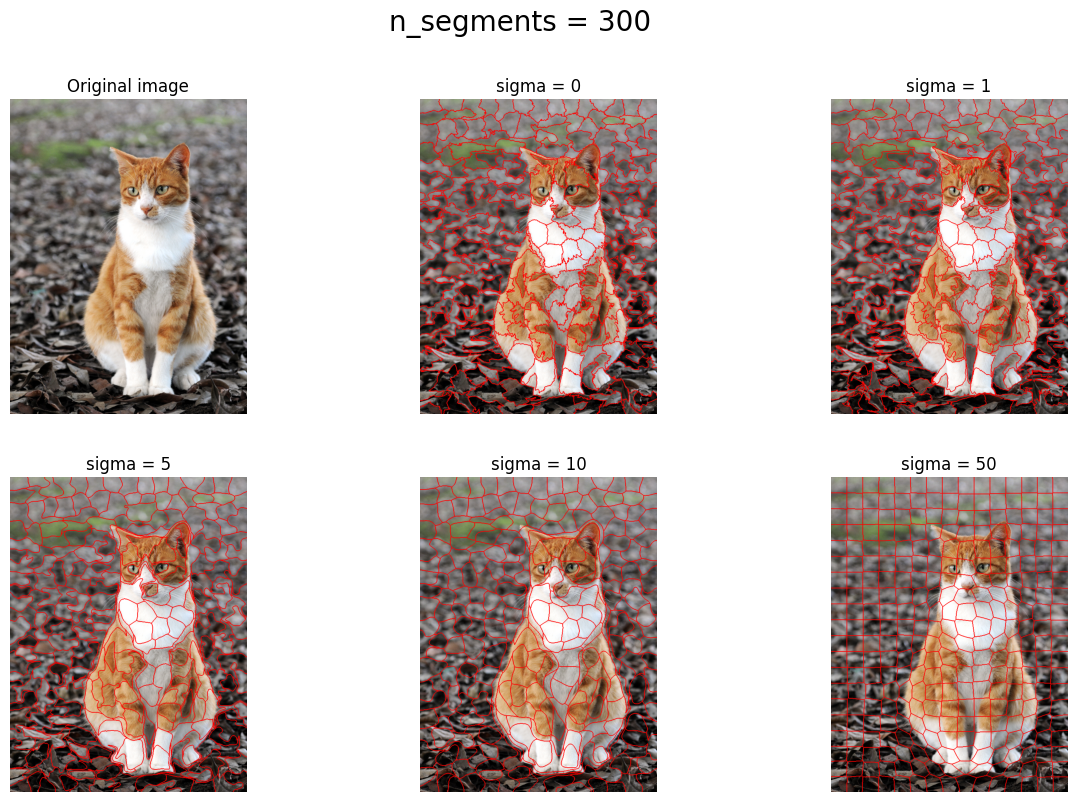

In [5]:
slic_segments_comparison(tabby, [50, 100, 300, 500, 1000])
slic_sigma_comparison(tabby, [0, 1, 5, 10, 50])

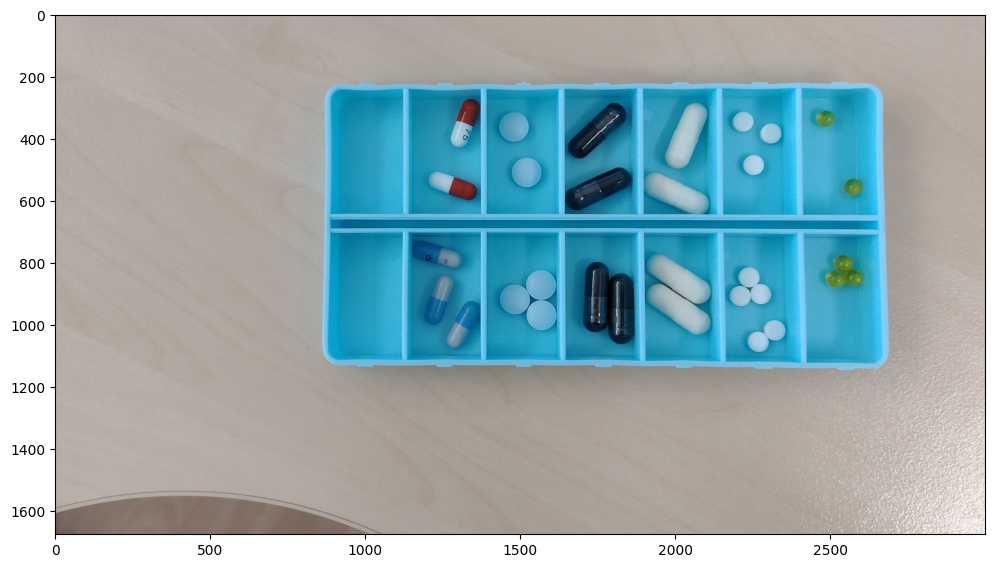

In [6]:
pills = cv2.imread('pills.png')[..., ::-1]
plt.subplots(1,1,figsize=(12,8))[1].imshow(pills);

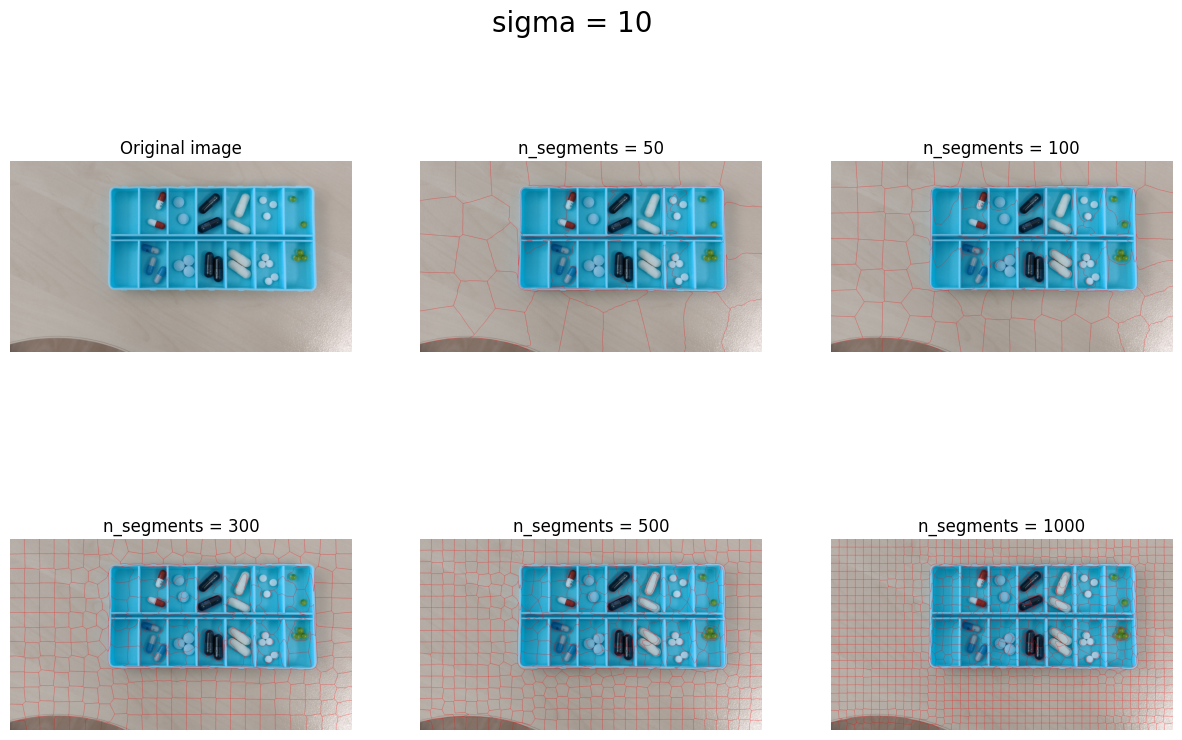

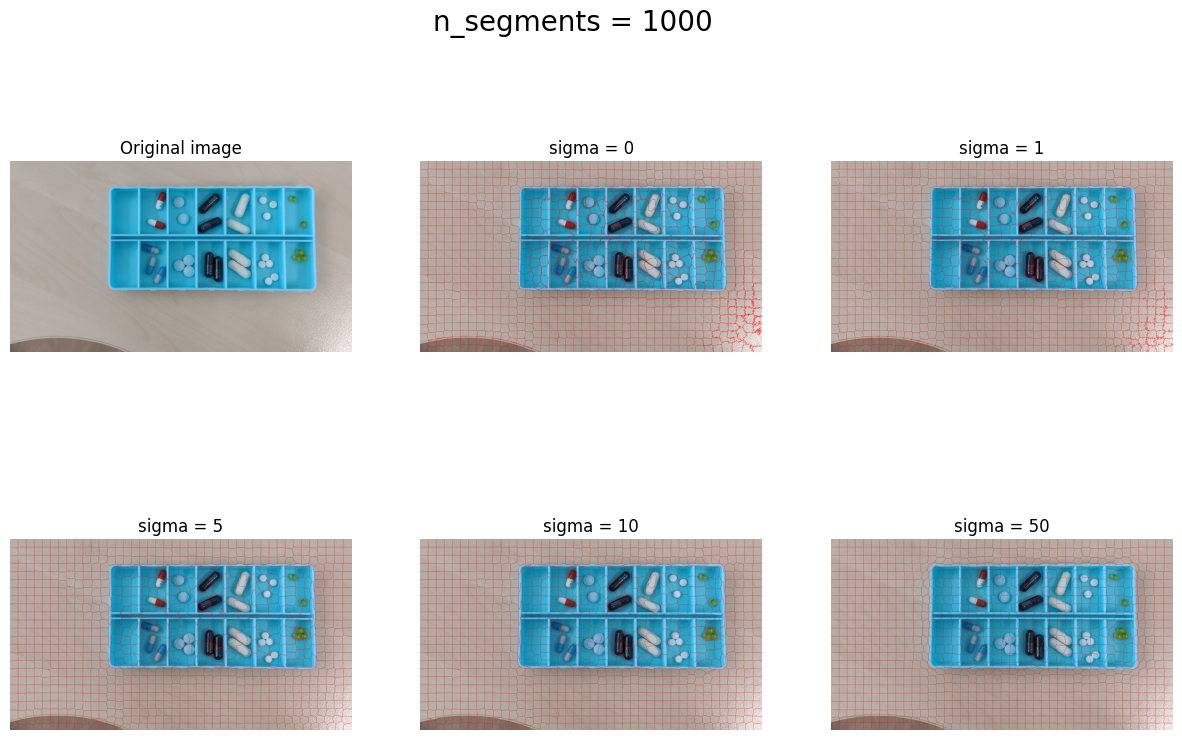

In [7]:
slic_segments_comparison(pills, [50, 100, 300, 500, 1000])
slic_sigma_comparison(pills, [0, 1, 5, 10, 50], n_segments = 1000)

#### Zadanie 2

Dla obrazu `tabby` wykonaj post-processing segmentacji SLIC by uzyskać dwa jednorodne obszary: jeden zawierający wyłącznie kota, drugi zawierający wyłącznie tło.

Można to zadanie potraktować jako binaryzację na poziomie superpikseli i zrealizować je za pomocą progowania. 
Można też potraktować je jako klasteryzację superpikseli i wykorzystać np. [`cv2.kmeans`](https://docs.opencv.org/4.x/d5/d38/group__core__cluster.html#ga9a34dc06c6ec9460e90860f15bcd2f88).  
Niezależnie od wybranej ścieżki, konieczne będzie opisanie każdego z superpikseli za pomocą jakiejś *cechy* go opisującej (lub kilku cech). Najprostszymi cechami mogą być np. średnie wartości składowych barwy pikseli wchodzących w skład superpiksela.  
Do zastanowienia: jakie parametry SLICa wybrać jako podstawę w tym zadaniu?

Zaprezentuj wyniki albo za pomocą `mark_boundaries` albo wyświetlając maskę binarną.

---

NumPy pro-tip: aby uzyskać zbiór wszystkich pikseli obrazu o wartości np. 3 możesz użyć notacji: ```obraz==3```. Wynikiem jest macierz boolowska, której można używać jako selektor. Np. aby na obrazie `A` wyzerować wszystkie piksele, którym w obrazie `B` odpowiada wartość 5, możesz napisać:  
```A[B==5] = 0```  
Ten zapis jest **znacznie** szybszy niż manualne iterowanie po obrazach i sprawdzanie warunków if-ami.

---

Przykładowe użycie `cv2.kmeans` (więcej możesz poczytać np. [tutaj](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_ml/py_kmeans/py_kmeans_opencv/py_kmeans_opencv.html)):
```python
c, labels, centers = cv2.kmeans(
    data=data,  # np.ndarray typu float o wymiarach NxK gdzie N to liczba sampli (u nas: superpikseli), K - liczba cech
    K=2,        # oczekiwana liczba klastrów
    bestLabels=None,
    criteria=(cv2.TERM_CRITERIA_EPS, 10, 1.0),  # przykładowe kryteria stopu
    attempts=1, # liczba powtórzeń algorytmu
    flags=cv2.KMEANS_RANDOM_CENTERS  # sposób inicjalizacji klastrów
)
```

Funkcja ta zwraca krotkę, której najważniejszym komponentem jest ten drugi (tu: `labels`), tj. macierz o wymiarach Nx1, zawierająca indeks klastra przypisanego i-temu samplowi.

In [8]:
# zacznij od przygotowania macierzy wejściowej (data) reprezentującej superpiksele jako punkty danych

### Analiza RGB

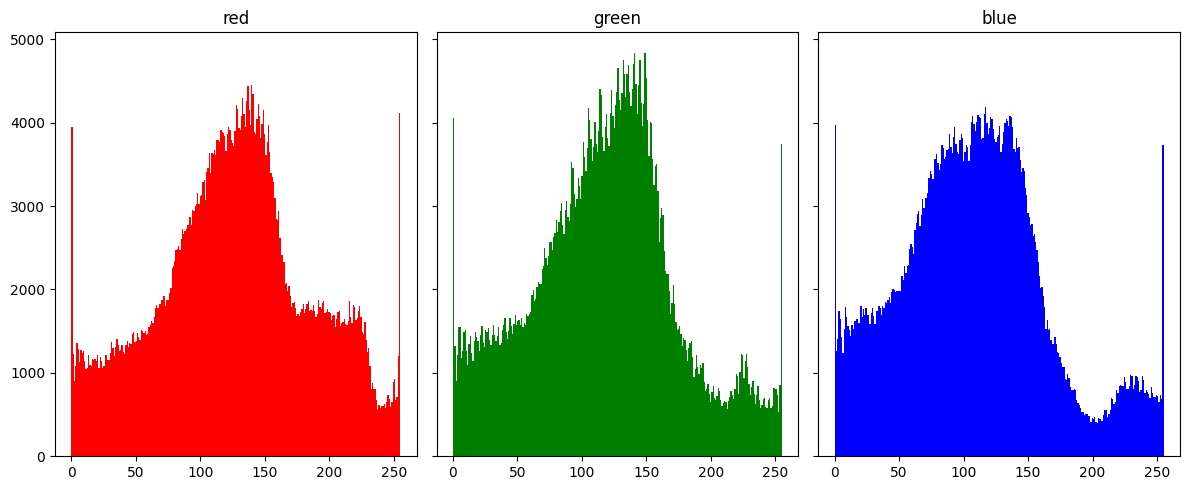

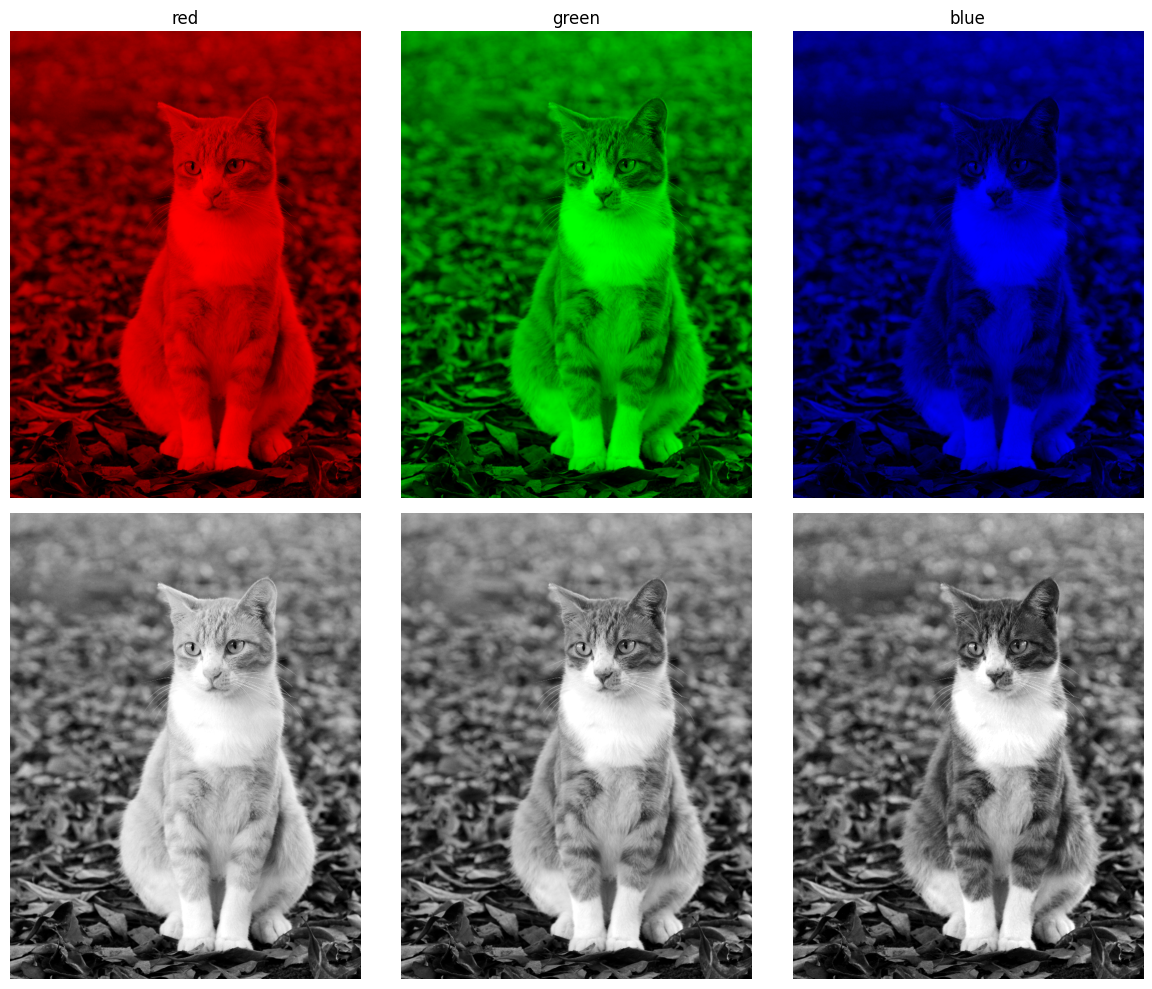

In [43]:
def channel_histograms(img):
    
    _, axs = plt.subplots(1, 3, figsize = (12, 5), sharey = True, tight_layout = True)
    colors = ['red', 'green', 'blue']
    
    for i in range(img.shape[-1]):
        axs[i].hist(img[..., i].reshape(-1), bins = 256, color = colors[i])
        axs[i].set_title(colors[i])
        
    plt.show()


def channel_images(img):
    _, axs = plt.subplots(2, 3, figsize = (12, 10), tight_layout = True)
    colors = ['red', 'green', 'blue']
    
    for i in range(img.shape[-1]):
        temp = [*range(img.shape[-1])]
        temp.remove(i)
        img_copy = img.copy()
        for j in temp:
            img_copy[..., j] = 0
        gray_img = cv2.cvtColor(img_copy, cv2.COLOR_RGB2GRAY)
        
        axs[0, i].imshow(img_copy)
        axs[0, i].set_title(colors[i])
        axs[0, i].axis('off')
        axs[1, i].imshow(gray_img, cmap = 'gray')
        axs[1, i].axis('off')
    plt.show()


channel_histograms(tabby)
channel_images(tabby)

### Analiza HSV

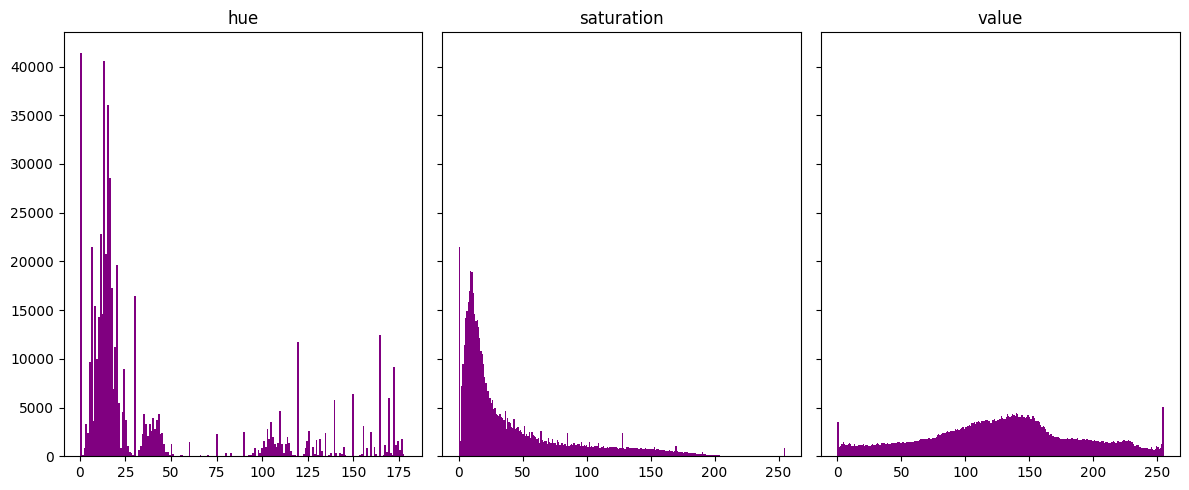

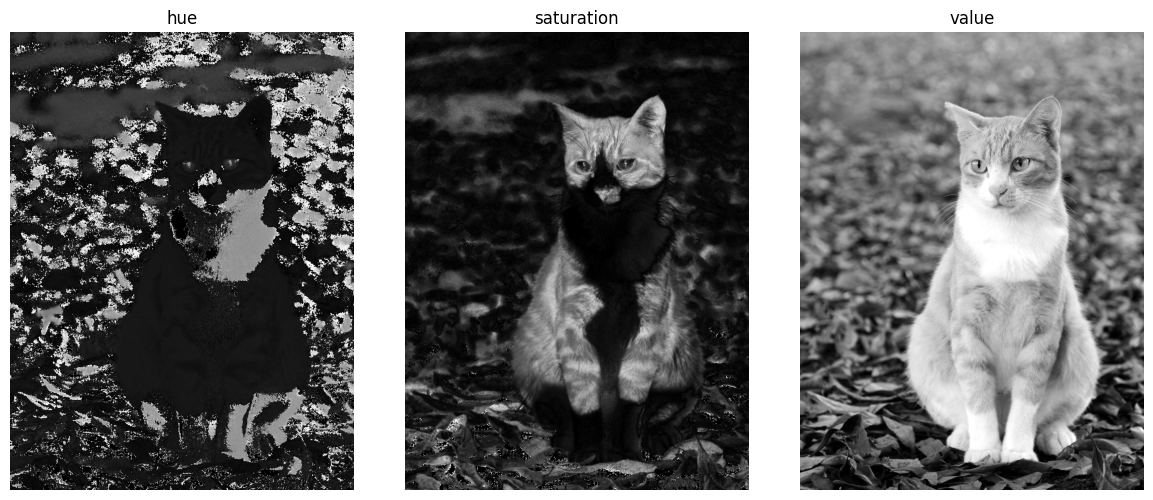

In [45]:
def channel_histograms_hsv(img):
    img_copy = img.copy()
    img_hsv = cv2.cvtColor(img_copy, cv2.COLOR_RGB2HSV)
    _, axs = plt.subplots(1, 3, figsize = (12, 5), sharey = True, tight_layout = True)
    
    axs[0].hist(img_hsv[..., 0].reshape(-1), bins = 180, color = 'purple')
    axs[0].set_title('hue')
    axs[1].hist(img_hsv[..., 1].reshape(-1), bins = 256, color = 'purple')
    axs[1].set_title('saturation')
    axs[2].hist(img_hsv[..., 2].reshape(-1), bins = 256, color = 'purple')
    axs[2].set_title('value')
        
    plt.show()
    
    
def channel_images_hsv(img):
    _, axs = plt.subplots(1, 3, figsize = (12, 5), tight_layout = True)
    channels = ['hue', 'saturation', 'value']
    
    for i in range(img.shape[-1]):
        temp = [*range(img.shape[-1])]
        temp.remove(i)
        img_copy = img.copy()
        img_hsv = cv2.cvtColor(img_copy, cv2.COLOR_RGB2HSV)[..., i]

        axs[i].imshow(img_hsv, cmap = 'gray')
        axs[i].set_title(channels[i])
        axs[i].axis('off')
    plt.show()

channel_histograms_hsv(tabby)
channel_images_hsv(tabby)

In [146]:
def segment_cat(img, **kwargs):
    # PARAMETRY KWARGS
    n_segments = kwargs.get('n_segments')
    sigma = kwargs.get('sigma')
    K = kwargs.get('K')
    bestLabels = kwargs.get('bestLabels')
    criteria = kwargs.get('criteria')
    attempts = kwargs.get('attempts')
    flags = kwargs.get('flags')
    # STWORZENIE SUPERPIKSELI
    segments = slic(img, n_segments = n_segments, sigma = sigma)
    unique_segments = np.unique(segments)
    segments_colors = list()
    # UTWORZENIE REPREZENTACJI SUPERPIKSELA
    for segment in unique_segments:
        segment_pixels = img[segments == segment]
        mean_color = segment_pixels.mean(axis = 0).round(0)
        segments_colors.append(mean_color)
        
    segments_colors = np.array(segments_colors)
    kmeans_colors = np.float32(np.expand_dims(segments_colors, axis = 1))
    # KMEANS
    _, labels, _ = cv2.kmeans(data = kmeans_colors,
                              K = K, 
                              bestLabels = bestLabels, 
                              criteria = criteria,
                              attempts = attempts,
                              flags = flags)
    # SEGMENTACJA OBIEKTU
    dct = dict(zip(unique_segments, labels))
    final_img = np.vectorize(lambda x: dct.get(x, x))(segments)
    
    return final_img

In [105]:
from typing import Literal

def take_one_channel(img, channel: Literal[0, 1, 2]):
    img_copy = img.copy()
    channels = [0, 1, 2]
    channels.remove(channel)
    img_copy[..., channels] = 0
    return img_copy

In [135]:
def compare_all(img, **kwargs):
    _, axs = plt.subplots(3, 4, figsize = (12, 15), tight_layout = True)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    titles_rgb = ['rgb', 'red', 'green', 'blue']
    titles_hsv = ['hsv', 'hue', 'saturation', 'value']
    titles_hls = ['hls', 'hue', 'lightness', 'saturation']
    
    axs[0, 0].imshow(segment_cat(img, **kwargs), cmap = 'gray')
    axs[0, 0].set_title(titles_rgb[0])
    axs[0, 0].axis('off')
    axs[1, 0].imshow(segment_cat(img_hsv, **kwargs), cmap = 'gray')
    axs[1, 0].set_title(titles_hsv[0])
    axs[1, 0].axis('off')
    axs[2, 0].imshow(segment_cat(img_hls, **kwargs), cmap = 'gray')
    axs[2, 0].set_title(titles_hls[0])
    axs[2, 0].axis('off')
    
    for i in range(3):
        axs[0, i + 1].imshow(segment_cat(take_one_channel(img, i), **kwargs), cmap = 'gray')
        axs[0, i + 1].set_title(titles_rgb[i + 1])
        axs[0, i + 1].axis('off')
        axs[1, i + 1].imshow(segment_cat(take_one_channel(img_hsv, i), **kwargs), cmap = 'gray')
        axs[1, i + 1].set_title(titles_hsv[i + 1])
        axs[1, i + 1].axis('off')
        axs[2, i + 1].imshow(segment_cat(take_one_channel(img_hls, i), **kwargs), cmap = 'gray')
        axs[2, i + 1].set_title(titles_hls[i + 1])
        axs[2, i + 1].axis('off')
    plt.show()

In [144]:
PARAMS = {'n_segments': 1000,
        'sigma': 1,
        'K': 2,
        'bestLabels': None,
        'criteria': (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0),
        'attempts': 20,
        'flags': cv2.KMEANS_RANDOM_CENTERS}

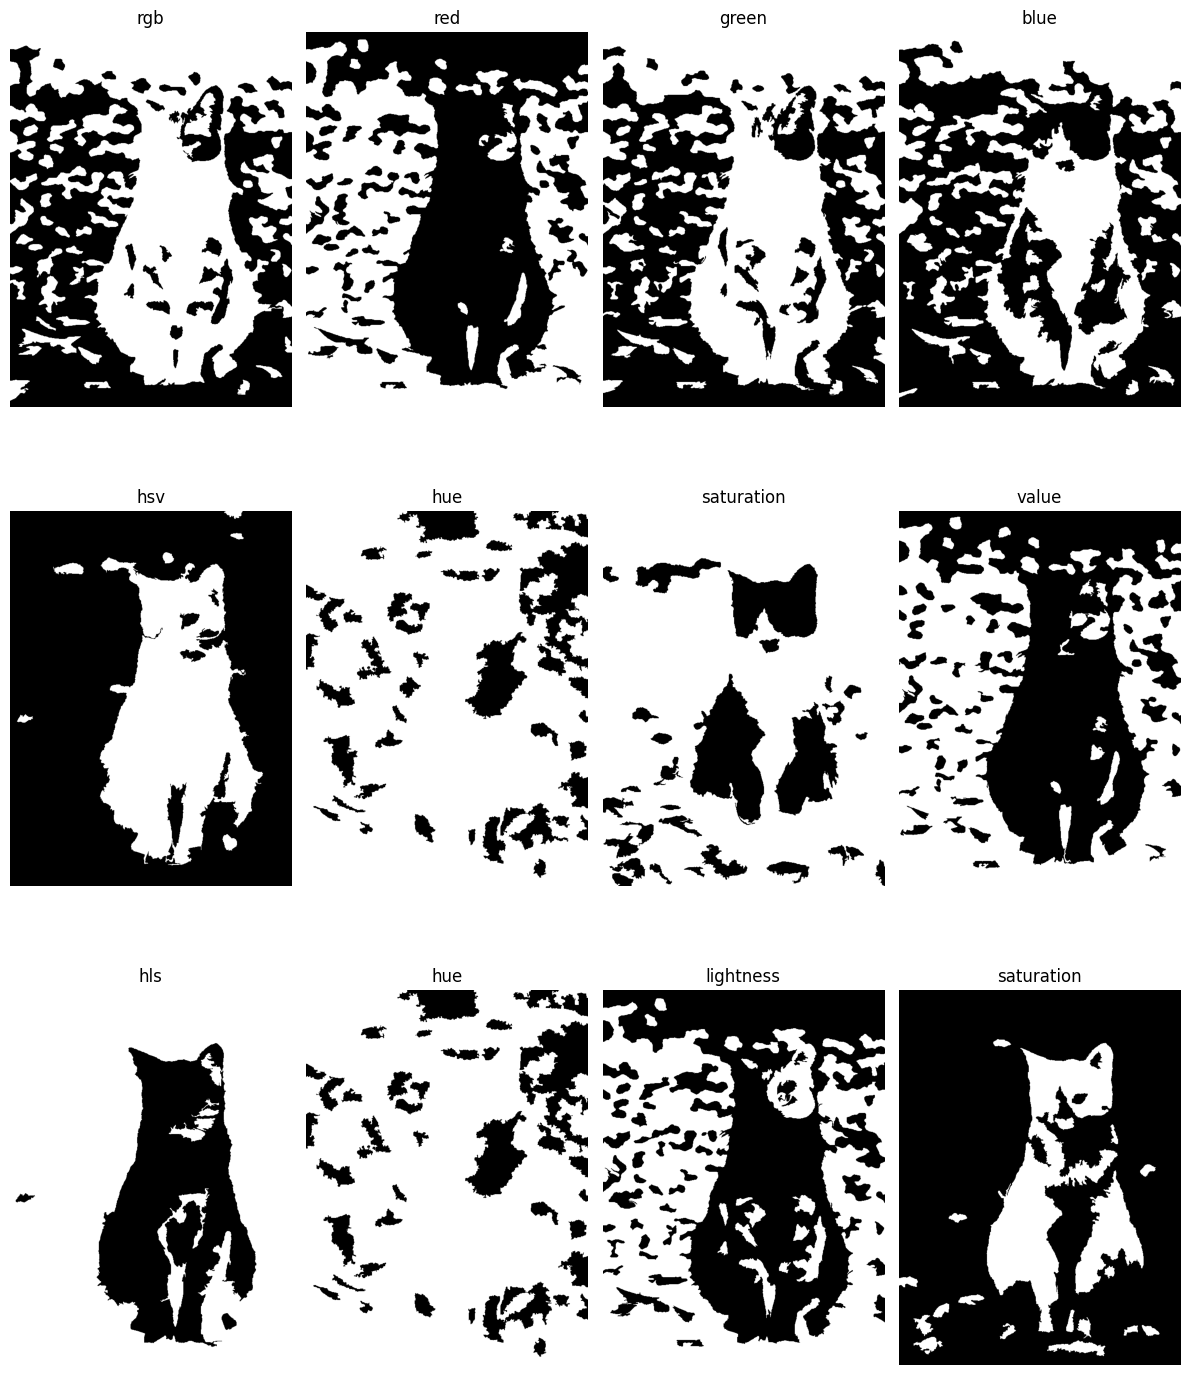

In [137]:
compare_all(tabby, **PARAMS)

Spośród poszczególnych kanałów/modeli najlepiej się sprawdziła segmentacja na modelu barw HSV i HSL. W związku z tym będziemy następnie optymalizować hiperparametry wyłącznie dla tych modeli barw. 

### TESTOWANIE PARAMETRÓW N_SEGMENTS I SIGMA

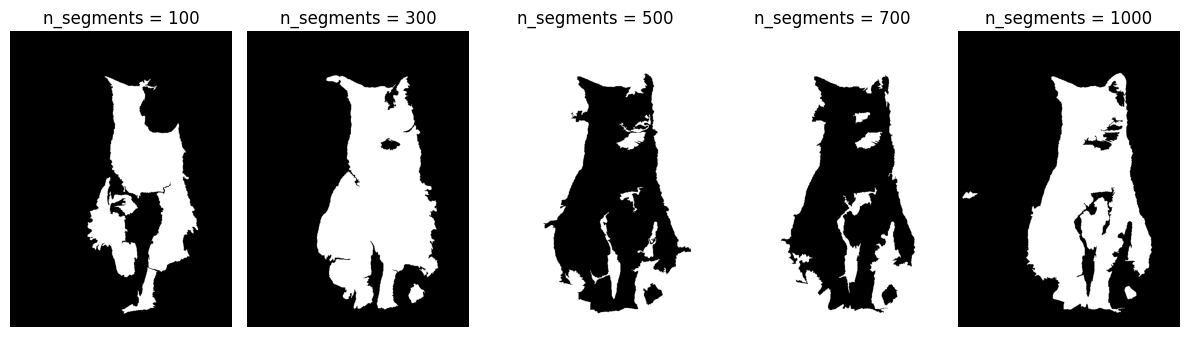

In [140]:
PARAMS2 = PARAMS.copy()
n_segments_list = [100, 300, 500, 700, 1000]
tabby_hls = cv2.cvtColor(tabby, cv2.COLOR_RGB2HLS)

_, axs = plt.subplots(1, 5, figsize = (12, 5), tight_layout = True)
for i, n in enumerate(n_segments_list):
    PARAMS2['n_segments'] = n
    axs[i].imshow(segment_cat(tabby_hls, **PARAMS2), cmap = 'gray')
    axs[i].set_title(f'n_segments = {n}')
    axs[i].axis('off')
plt.show()

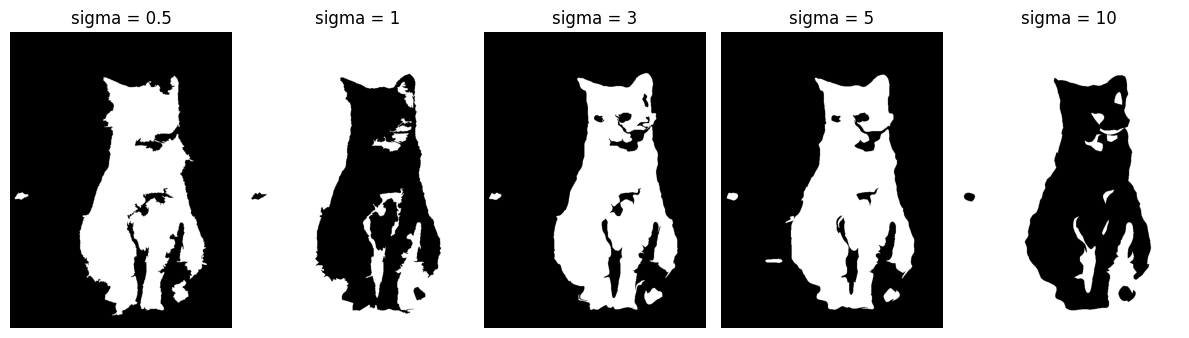

In [147]:
PARAMS3 = PARAMS.copy()
sigma_list = [.5, 1, 3, 5, 10]
tabby_hls = cv2.cvtColor(tabby, cv2.COLOR_RGB2HLS)

_, axs = plt.subplots(1, 5, figsize = (12, 5), tight_layout = True)
for i, n in enumerate(sigma_list):
    PARAMS3['sigma'] = n
    axs[i].imshow(segment_cat(tabby_hls, **PARAMS3), cmap = 'gray')
    axs[i].set_title(f'sigma = {n}')
    axs[i].axis('off')
plt.show()

### EROZJA I DYLACJA

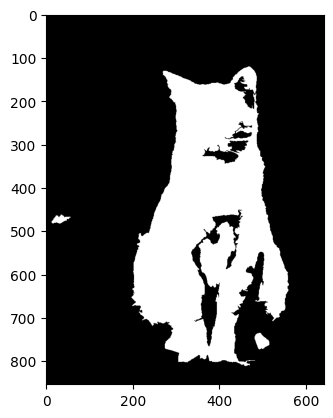

In [155]:
better_tabby = segment_cat(tabby_hls, **PARAMS).astype(np.uint8)
plt.imshow(better_tabby, cmap = 'gray')

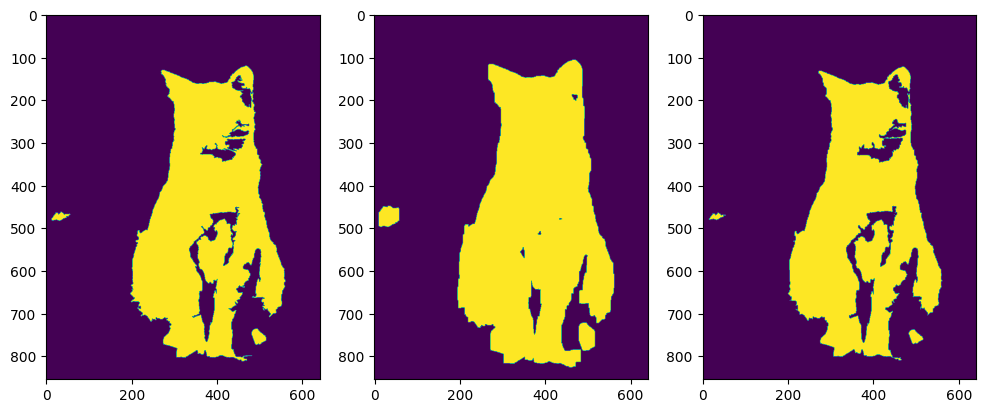

In [173]:
kernel = np.ones((5, 1), np.uint8)

dilation = cv2.dilate(better_tabby, np.ones((5, 1), np.uint8), iterations=7)
dilation2 = cv2.dilate(dilation, np.ones((1, 5), np.uint8), iterations=1)
erosion = cv2.erode(better_tabby, kernel, iterations=1)

_, axs = plt.subplots(1, 3, figsize=(12, 5))
axs[0].imshow(better_tabby)
axs[1].imshow(dilation2)
axs[2].imshow(erosion)
plt.show()